<a href="https://colab.research.google.com/github/nkanungo/EVA6/blob/main/Assignment3_EVA6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Assignment-3 
===============
Program :      EVA-6

Submitted by : Nihar Kanungo

Requirement 
===============

Write a neural network that can:
take 2 inputs:

1. An image from MNIST dataset, and
2. A random number between 0 and 9

and gives two outputs:

1. The "number" that was represented by the MNIST image, and
2. The "sum" of this number with the random number that was generated and sent as the input to the network

![alt text](imagename.png "Requirement Diagram")

What's Allowed
=================  
1. you can mix fully connected layers and convolution layers
2. you can use one-hot encoding to represent the random number input as well as the "summed" output. 

Your code MUST be:
======================
1. well documented (via readme file on github and comments in the code)
2. must mention the data representation
3. must mention your data generation strategy
4. must mention how you have combined the two inputs
5. must mention how you are evaluating your results
6. must mention "what" results you finally got and how did you evaluate your results
7. must mention what loss function you picked and why!
8. training MUST happen on the GPU


In [ ]:
# Pytorch's tensors are similar to Numpy's ndarrays
# Install Pytorch 
!pip install torch



### A common nn pipeline looks like this:
1. Prepare the data
2. Build the model
3. Train the model
4. Analyze the model

# Import all required Libraries for the Program

In [ ]:
import torch
import torchvision # provide access to datasets, models, transforms, utils, etc
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F



In [ ]:
# Download the MNIST Dataset to the data folder

train_set = torchvision.datasets.MNIST(
    root='./data'
    ,train=True
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor()
    ])
)



Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Let's perform some basic testing to ensure that the data is properly downloaded 

1. Set the print option
2. The Number of training examples
3. Print some labels in the trained data

In [ ]:
torch.set_printoptions(linewidth=120)

In [ ]:
len(train_set)

60000

In [ ]:
train_set.train_labels

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:54: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


tensor([5, 0, 4,  ..., 5, 6, 8])

# Balanced Dataset

It's very important to check and ensure that the dataset is balanced inorder to esnure that the outcome is not boased towards any specific class . 

In [ ]:
train_set.train_labels.bincount() #frequency of each label, we have balanced class here

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:54: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


tensor([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949])

# Print sample data 



In [ ]:
sample = next(iter(train_set))

len(sample)

2

In [ ]:
image, label = sample

label: 5


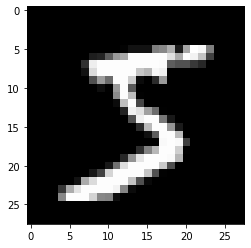

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(image.squeeze(), cmap='gray')
print('label:', label)

# Let's Build the Main Model Now 

1. Define the Network Class 
   This is the main class of the Program which defines the model structure and forward function 

2. Init Function -

   i)  Includes 3 Convolution Layers ( 3 x3  with 2 layers and 5 x 5 with 1 layer)
   Normally it's advisabel to use many 3 x3 layers until the image size is 11 x 11 . But as MNIST isa easy dataset so i have used variety of kernels to show the usabe. I have also not gone down till 11 x11 as it should anyway give > 97-98% accuracy 

   ii) Few Linear layers for (Fully connected) for MNIST dataste

   iii) 2 Layers to process combined data (MNIST + Random Number)


Forward Function
--------------------
1. MNIST Data Processing
  
  i) Conv1  - 3 x 3 kernel - Target Image size - 26 x 26
 
  ii) Conv2 - 3 x 3 kernel - Target Image Size - 24 x 24
 
  iii) Maxpool2D  - Stride -2 - Target Image size - 12 x 12
 
  iv ) Conv 3 - 5 x 5 kernel -  Target Image Size - 8 x 8
  
  v)   Maxpool2D stride2 - Target Image size 4 x 4 

  vi) Fully Connected layer FC1, FC2 
  
  vii) Output Layer

2. Random Data + MNIST 

   i) Concatenate  the Random Number after FC2 Layer - Now the Targets are 20 
 
   ii) Pass the data through FC3 Layer

   iii) Output layer 



Below is the basic structure of a Model

In [ ]:
import torch.nn as nn
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=24 * 4 * 4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.fc3 = nn.Linear(in_features=20, out_features=40)
        self.out = nn.Linear(in_features=60, out_features=10)
        self.out_rand = nn.Linear(in_features=40, out_features=20)


    def forward(self, t, rand_no):
        
        t = t
       

        # (2) hidden conv layer
        t = self.conv1(t)
        t = F.relu(t)
        
        # (3) hidden conv layer
        t = self.conv2(t)
        t = F.relu(t)
        
        # Maxpooling 
        t = F.max_pool2d(t, kernel_size=2, stride=2)
       

        # (4) hidden conv layer
        t = self.conv3(t)
        t = F.relu(t)
        
        #Maxpooling
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        

        # (5) hidden linear layer
        t = t.reshape(-1, 24 * 4 * 4)
        t = self.fc1(t)
        t = F.relu(t)
        
       #(6) hidden linear layer
       
        # for the random layer
        t = self.fc2(t)
        t = F.relu(t)


        
        # (7) output layer for MNIST Data
        t = self.out(t)
        

        # Pre-processing For random number layer
        rand_no = F.one_hot(rand_no, num_classes=10)
        rand_no = torch.cat((t ,rand_no),dim=1)
        
        #(8) hidden linear layer
        rand_no = self.fc3(rand_no)

        # (9) output layer for MNIST Data + Random Data
        rand_no = self.out_rand(rand_no)
        
        #t = F.softmax(t, dim=1)

        return t, rand_no

# Training

During the entire training process, we do as many epochs as necessary to reach our desired level of accuracy. With this, we have the following steps:

Get batch from the training set.
Pass batch to network.
1. Calculate the loss (difference between the predicted values and the true values).
2. Calculate the gradient of the loss function w.r.t the network's weights.

3. Update the weights using the gradients to reduce the loss.

4. Repeat steps 1-5 until one epoch is completed.

5. Repeat steps 1-6 for as many epochs required to reach the minimum loss.

In [ ]:
import torch.optim as optim

torch.set_grad_enabled(True) 

# To find out number of correct prediction and return to the calling function

In [ ]:
def get_num_correct(preds, labels):
  #print(preds.shape, labels.shape)
  return preds.argmax(dim=1).eq(labels).sum().item()
 

Processing Steps
====================
1. Create a Training data loader
2. define Batchsize, Optimizer and Learning Rate
3. Run the Model for 100 Epochs
4. Run the Model training by passing images and random numbers of same batch size
5. Calculate Loss for MNIST and MNIST + Random Number
6. Add both loss to find Total Loss
7. Calculate Gradient
8. Update weights
9. Display Parameter 







In [ ]:
network = Network()

#      torch.utils.data.DataLoader` is an iterator which provides all these features:
#    * Batching the data
#    * Shuffling the data
#    * Load the data in parallel using multiprocessing workers.

train_loader = torch.utils.data.DataLoader(train_set, batch_size=100,shuffle=True)
optimizer = optim.Adam(network.parameters(), lr=0.01)
#i = 0

for epoch in range(100):

    total_loss = 0
    total_correct = 0
    total_correct_random = 0
    total_incorrect = 0
    total_incorrect_random = 0

    
    for batch in train_loader: # Get Batch
        images, labels = batch 
        randno = torch.randint(low=0,high=10,size=(100,))
        labels_random = randno+labels
        preds,preds_random = network(images,randno) # Pass Batch
        
        loss = F.cross_entropy(preds, labels) # Calculate Loss
        loss_random = F.cross_entropy(preds_random, labels_random)
        loss = loss + loss_random
        optimizer.zero_grad()
        loss.backward() # Calculate Gradients
        optimizer.step() # Update Weights

        total_loss += loss.item()
        total_correct += get_num_correct(preds, labels)

        
        total_correct_random += get_num_correct(preds_random, labels_random)
        
        
        #total_incorrect += labels.shape[0] - total_correct
        #accuracy_MNIST = total_correct/ (total_correct + total_incorrect )
        # loss_random = F.cross_entropy(preds_random, labels_random)
        # #loss = loss + loss_random
        # optimizer.zero_grad()
        # loss_random.backward() # Calculate Gradients of random
        # optimizer.step() # Update Weights
        # total_loss_random += loss_random.item()
        #total_incorrect_random += labels_random.shape[0] - total_correct_random
        #accuracy_random = total_correct_random/ (total_correct_random + total_incorrect_random )
        #if i < 5:
        # print('Total correct',total_correct )
        # print('Total incorrect',total_incorrect )
        # print('Accuracy of Batch ',total_correct/(total_correct+total_incorrect ) )
        # print('Total Random correct',total_correct_random )
        # print('Total Random incorrect',total_incorrect_random )
        # print('Accuracy of Batch with random number ',total_correct_random/(total_correct_random+total_incorrect_random ) )

        # #i+=1


    print(
        "epoch", epoch, 
        "total_correct:", total_correct, 
        "total_correct_random:", total_correct_random, 
        "accuracy MNIST:", total_correct/60000,
        "accuracy Random:", total_correct_random/60000,
        "MNIST loss:", loss,
        "Random loss:", loss_random,
        "loss:", total_loss
    )

    

epoch 0 total_correct: 56576 total_correct_random: 30095 accuracy MNIST: 0.9429333333333333 accuracy Random: 0.5015833333333334 MNIST loss: tensor(1.2909, grad_fn=<AddBackward0>) Random loss: tensor(1.1349, grad_fn=<NllLossBackward>) loss: 904.2589326500893
epoch 1 total_correct: 58870 total_correct_random: 43661 accuracy MNIST: 0.9811666666666666 accuracy Random: 0.7276833333333333 MNIST loss: tensor(0.6713, grad_fn=<AddBackward0>) Random loss: tensor(0.6479, grad_fn=<NllLossBackward>) loss: 542.3122572898865
epoch 2 total_correct: 58997 total_correct_random: 47271 accuracy MNIST: 0.9832833333333333 accuracy Random: 0.78785 MNIST loss: tensor(0.7216, grad_fn=<AddBackward0>) Random loss: tensor(0.6619, grad_fn=<NllLossBackward>) loss: 469.3573463857174
epoch 3 total_correct: 59061 total_correct_random: 50430 accuracy MNIST: 0.98435 accuracy Random: 0.8405 MNIST loss: tensor(0.4391, grad_fn=<AddBackward0>) Random loss: tensor(0.4332, grad_fn=<NllLossBackward>) loss: 425.2137030661106
ep

Observations
================
------------------


1. Tried to concatenate the Random Numbers at various steps 

i) At the beginning
ii) At the FC1 Layer
iii) FC2 Layer 

All these steps threw higher loss as we had to add the data as one value

Then tried to add the value once the MNIST data reduced to 10 values making it 20 

The loss seems to reduce with decent accuracy 

2. Updated 5 x5 with 3x3 and many layers

Didnot see any significant improvement on the accuracy as MNIST data is very simple and any model can get upto 98% accuracy

3. Modified Data loader and tried but it didnot give any better accuracy 

4. One hot encoding is the only one to be tried. Could not find time to try other things . Hope to try in future
-------------------------------------------